<a href="https://colab.research.google.com/github/rctn/sparsecoding/blob/harrison%2Fwhiten/examples/Data_Whitening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will teach you how to use our sparsecoding repo for data whitening. We will cover
- How to whiten arbitrary data
- Our additional support for whitening images

In [ ]:
# Run this cell if you are on colab
#!git clone https://github.com/rctn/sparsecoding
#%cd /content/sparsecoding
#import os
#os.environ['PYTHONPATH'] = f"/content/sparsecoding:{os.environ.get('PYTHONPATH', '')}"

Cloning into 'sparsecoding'...
remote: Enumerating objects: 1626, done.
remote: Counting objects: 100% (583/583), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 1626 (delta 367), reused 364 (delta 309), pack-reused 1043 (from 1)
Receiving objects: 100% (1626/1626), 28.01 MiB | 11.58 MiB/s, done.
Resolving deltas: 100% (891/891), done.
/content/sparsecoding


# Setup
Run the following cells for imports and to define some functions we use for visualization.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from sparsecoding.transforms import whiten
import time
import os

def visualize_whitening_methods(X):
    """
    Visualize data before and after applying different whitening transformations using color gradients.
    Points maintain their original colors after transformation to show the mapping.

    Args:
        X (torch.Tensor): Input tensor of shape [N, 2]
    """
    # Apply different whitening methods
    X_whitened_pca = whiten(X, algorithm='pca')
    X_whitened_zca = whiten(X, algorithm='zca')
    X_whitened_cholesky = whiten(X, algorithm='cholesky')

    X_np = X.detach().cpu().numpy()
    X_whitened_pca_np = X_whitened_pca.detach().cpu().numpy()
    X_whitened_zca_np = X_whitened_zca.detach().cpu().numpy()
    X_whitened_cholesky_np = X_whitened_cholesky.detach().cpu().numpy()

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    x_norm = (X_np[:, 0] - X_np[:, 0].min()) / (X_np[:, 0].max() - X_np[:, 0].min())
    y_norm = (X_np[:, 1] - X_np[:, 1].min()) / (X_np[:, 1].max() - X_np[:, 1].min())
    colors = np.stack([x_norm, y_norm, np.ones_like(x_norm) * 0.5], axis=1)

    data_sets = [
        (X_np, "Original Data"),
        (X_whitened_pca_np, "PCA Whitened"),
        (X_whitened_zca_np, "ZCA Whitened"),
        (X_whitened_cholesky_np, "Cholesky Whitened")
    ]

    all_data = np.vstack([X_np, X_whitened_pca_np, X_whitened_zca_np, X_whitened_cholesky_np])
    max_val = max(abs(all_data.min()), abs(all_data.max()))

    for ax, (data, title) in zip(axes, data_sets):
        scatter = ax.scatter(data[:, 0], data[:, 1],
                           c=colors, alpha=0.6, s=50)
        ax.set_title(f'{title}\n(color shows original x-y coordinates)')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)
        ax.axvline(x=0, color='k', linestyle='--', alpha=0.3)
        ax.set_xlim(-max_val, max_val)
        ax.set_ylim(-max_val, max_val)
        ax.set_aspect('equal')

        dummy = ax.scatter([], [], c=[], cmap='rainbow')
        cbar = plt.colorbar(dummy, ax=ax)
        cbar.set_label('Original coordinate values')

    plt.suptitle('Comparison of Whitening Transformations', fontsize=14)
    plt.tight_layout()
    plt.show()

In [2]:
def load_dataset(data_dir='../img', batch_size=32, color = True):

    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1) if not color else transforms.Lambda(lambda x: x)
    ])

    download = not os.path.exists(data_dir)

    full_dataset = datasets.Imagenette(
        root=data_dir,
        download=download,
        transform=transform
    )

    loader = DataLoader(
        full_dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )

    return loader

def display_random_images(loader, n=16, figsize=(4, 4)):

    images, labels = next(iter(loader))

    # If batch is smaller than n, adjust n
    n = min(n, len(images))

    indices = torch.randperm(len(images))[:n]

    selected_images = images[indices]

    img_grid = make_grid(selected_images, nrow=int(np.sqrt(n)))

    img_grid = img_grid.numpy().transpose((1, 2, 0))

    plt.figure(figsize=figsize)
    plt.imshow(img_grid)
    plt.axis('off')

    plt.show()

def display_images(imgs, title = None):

    is_grayscale = imgs.shape[1] == 1
    fig, axes = plt.subplots(1, 4, figsize=(8, 4))

    for i in range(4):
        img = imgs[i].permute(1, 2, 0).cpu().numpy()
        if is_grayscale:
            img = img.squeeze()
        axes[i].imshow(img, cmap='gray' if is_grayscale else None)
        axes[i].axis('off')

    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

def display_whitened_images(imgs, title = None):

    is_grayscale = imgs.shape[1] == 1

    fig, axes = plt.subplots(1, 4, figsize=(8, 4))

    for i in range(4):
        img = imgs[i].permute(1, 2, 0).cpu().numpy()
        if is_grayscale:
            img = img.squeeze()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
        axes[i].imshow(img, cmap='gray' if is_grayscale else None)
        axes[i].axis('off')

    if title:
        plt.title(title)

    plt.tight_layout()
    plt.show()

# Intro

Image whitening (also known as sphering) is a preprocessing technique that transforms a dataset with correlated features into one where the features are uncorrelated and have unit variance.  The process involves applying a linear transformation to the data that essentially "spreads out" the data points in a way that eliminates redundant information and standardizes the statistical properties. More formally, it converts a $d$-dimensinoal vector $x = (x_1, ..., x_d)^T$ with mean $\mu$ and covaraince matrix $\Sigma$ into a new random vector
$$ z = Wx$$
of the same dimension $d$, where $z$ has $\mu = 0$ and $\Sigma = I_d$. Here, $W$ is called the **whitening matrix**.
<br><br>

The primary motivation for image whitening in machine learning and computer vision is to make the learning process more efficient and effective. When features in the input data are correlated, learning algorithms often struggle because they need to implicitly discover and account for these correlations. By decorrelating the features beforehand, we make the learning task easier - each feature becomes independently informative, and the optimization landscape becomes better conditioned. Interestingly, research has shown retina performs a similar decorrelation and filtering through it's biological encoding.

For more technical details, read
- [Optimal whitening and decorrelation](https://arxiv.org/abs/1512.00809) by Kessy, Lewin, and Strimmer
- [Natural Image Statistics and Neural Representation](https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://www.cns.nyu.edu/pub/eero/simoncelli01-reprint.pdf&ved=2ahUKEwiAnLOBpdOJAxV_SDABHfi9NCkQFnoECAoQAQ&usg=AOvVaw2Yo6uyuebOGQFXgxbYUyly) by Simoncelli and Olshausen

----



# Whitening Data
We hope that our repo is structured in a way that allows for easy adaptation to any data modality. At the lowest level, we provide functions that expect data of shape $[N, D]$, where $N$ is the number of datapoints, and $D$ is each datapoint's dimensionality. Using these, you can construct higher level wrappers that are catered to your data. Before we show a wrapper for images, let's look at the core. Here you can use:

`whiten()` - This function provides access to three different whitening algorithms (zca, pca, and cholesky).

Let's see it used in a toy example, where we define some 'random' matrices and then whiten them

In [3]:
from sparsecoding.transforms import whiten

def verify_whitening(whitened_X):

  if -1e-3 < torch.mean(whitened_X) < 1e-3:
    print('mean is zero')
  else:
    print('ERROR: mean is not zero')

  D = whitened_X.shape[1]
  cov = torch.cov(whitened_X.T)
  if torch.allclose(cov,
                    torch.eye(D, dtype = torch.float32),
                    atol = 1e-3):
    print('cov is unit mat')
  else:
    print('ERROR: cov is not unit mat')



print('using zca')
X = torch.randn(5000, 32*32)
whitened = whiten(X, 'zca')
verify_whitening(whitened)

print('\nusing pca')
X = torch.randn(5000, 32*32)
whitened = whiten(X, 'pca')
verify_whitening(whitened)

print('\nusing cholesky')
X = torch.randn(5000, 32*32)
whitened = whiten(X, 'cholesky')
verify_whitening(whitened)

using zca
mean is zero
cov is unit mat

using pca
mean is zero
cov is unit mat

using cholesky
mean is zero
cov is unit mat


So if they all end up with whitened data, why have different algorithms? To see, let's visualize their effect on the data on some 2D datapoints. Here we will create some correlated data, and then see the output of each whitening algorithm

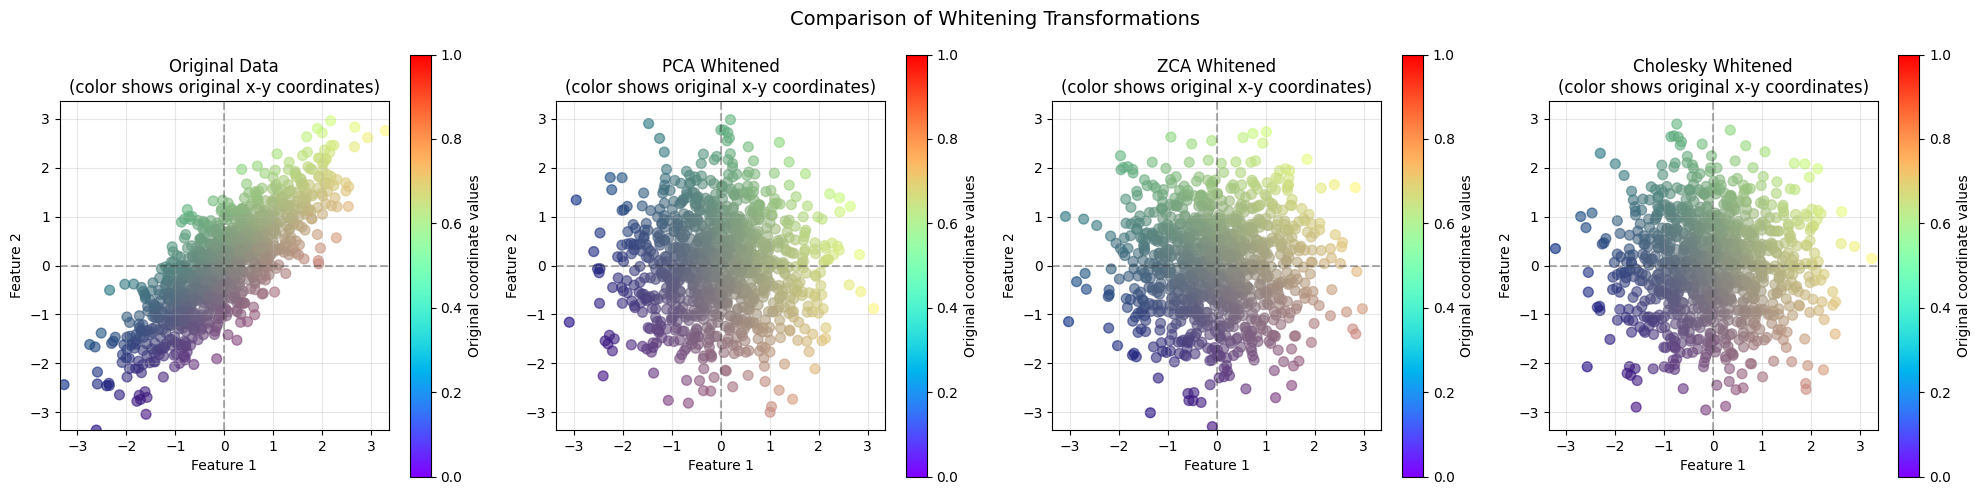

In [4]:
n_samples = 1000
mean = torch.zeros(2)
cov = torch.tensor([[1.0, 0.8],
                    [0.8, 1.0]])
mvn = torch.distributions.MultivariateNormal(mean, cov)
X = mvn.sample((n_samples,))

# Example usage with your whitening function:
visualize_whitening_methods(X)

While they all are whitened, they all are rotated differently! This is due to the fact that the whitening matrix (or whitening transform) is not unique, as the data remains whitened (i.e. \Sigma = I) under rigid rotation. In two dimensions this is a trivial difference, but as we will see with images, this can have dramatic effects. As a brief explanation of how each works:

- PCA Whitening: First rotates the data to align with principal components (eigenvectors of covariance matrix), then scales each dimension by the eigenvalues

- ZCA Whitening (Mahalanobis whitening): Performs PCA whitening then rotates back to the original feature space. This results in the whitened data that is as close as possible to original data in Euclidean sense

- Cholesky Whitening: Uses Cholesky decomposition of the covariance matrix (Σ = LL^T), here there is no explicit rotation to principal components

Now for many use cases, you may want to compute your whitening matrix using one dataset, and then apply that same matrix to new dataset. But each whitening algorithm requires different statistics in order to create $W$. This creates a problem, how can we compute and store all the statistics from our first dataset in a way that gives the flexibility to create any W later on? `compute_whitening_statistics()` solves this problem. Let's see it in action.

In [5]:
from sparsecoding.transforms import compute_whitening_stats

mvn = torch.distributions.MultivariateNormal(mean, cov)
X_1 = mvn.sample((n_samples,))
X_2 = mvn.sample((n_samples,))

# Compute whitening statistics on X_1
stats = compute_whitening_stats(X_1)
print("Available statistics:", stats.keys())

# Apply whitening transformations to X_2
whitened_X = whiten(X_2, stats=stats, algorithm='zca')


Available statistics: dict_keys(['mean', 'eigenvalues', 'eigenvectors', 'covariance'])


# Whitening Images

This repo is currently geared towards vision, so we provide additional functionality for whitening images. This is done via wrappers that take in tensors of shape $[N, C, H, W]$, do some checking/reshaping, and return whitened versions of those images.

Let's download a subsection of Imagenette and play around with it! We'll be experimenting with both greyscale and color images

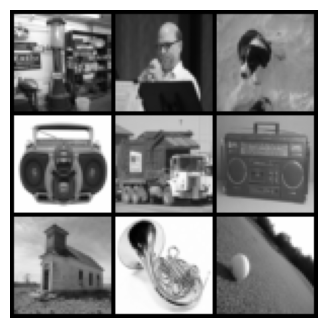

In [3]:
dataloader = load_dataset(color = False, batch_size = 32)
display_random_images(dataloader, n=9)

We'll be computing our stats on a different set than we whiten, so let's quickly get two different tensors of images. When doing eigen decomp, you want $N >> D$, so let's get make sure $N > C * H * W$.

In [4]:
from sparsecoding.transforms import whiten_images

sample_images = []
test_images = None
for batch, _ in dataloader:
  if len(sample_images) < 150:
    sample_images.append(batch)
  else:
    test_images = batch
    break

sample_images = torch.cat(sample_images, dim = 0)
print(f'{sample_images.shape=}')
print(f'{test_images.shape=}')

sample_images.shape=torch.Size([4800, 1, 48, 48])
test_images.shape=torch.Size([32, 1, 48, 48])


And now let's whiten them! This is made easy through `whiten_images` and `compute_image_whitening_stats`. Similar to above, we just pass in tensors and what algorithm we want to use. First let's use the zca-algorithm since it provides a tensor most similar to the original data

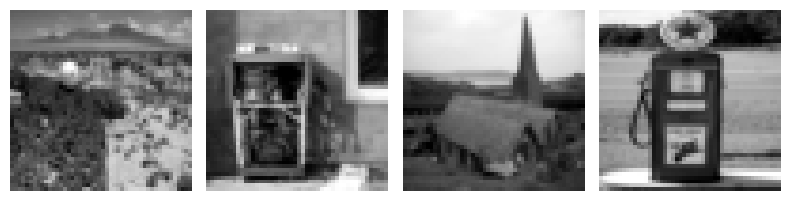

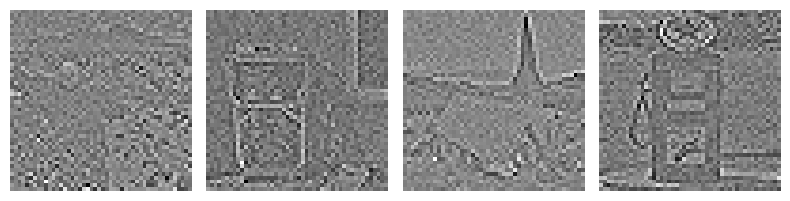

In [5]:
from sparsecoding.transforms import compute_image_whitening_stats

whitened_stats = compute_image_whitening_stats(sample_images)

whitened = whiten_images(test_images, algorithm = 'zca', stats = whitened_stats)

display_images(test_images)
display_whitened_images(whitened)

The images definitaly got transformed, but they look incredibly fuzzy. Why is this?

The problem is that when whitening you need to invert the variances/eigenvalues. For very high frequency principal components, those variances are very small, sometimes below the noise level. Therefore, when they're inverted, you're just amplifying noise. As a hueristic, we've found that adding a small epsilon value here reduces the noize amplification.

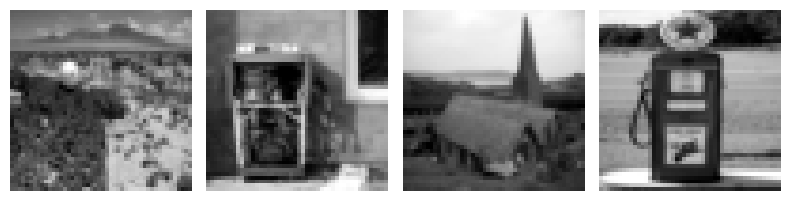

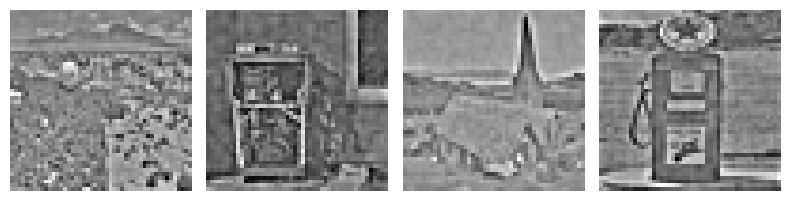

In [6]:
from sparsecoding.transforms import compute_image_whitening_stats

whitened = whiten_images(test_images, algorithm = 'zca', stats = whitened_stats, epsilon = 1e-2)

display_images(test_images)
display_whitened_images(whitened)

And what about the other transforms? We've established the PCA-algorithm doesn't rotate your data back to the original space. This means that the image becomes meaningless from a visual perspective (but still may be useful depending on your downstream tasks).

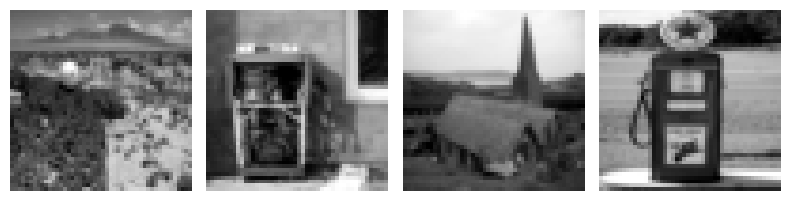

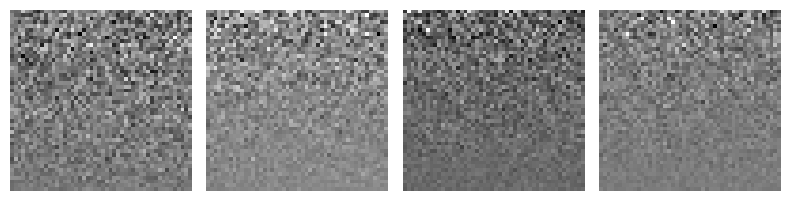

In [7]:
whitened = whiten_images(test_images, algorithm = 'pca', stats = whitened_stats, epsilon = 1e-2)

display_images(test_images)
display_whitened_images(whitened)

And since the Cholesky algorithm never rotates to-and from-principal components, it produces a tensor that is meaningful in image-space.

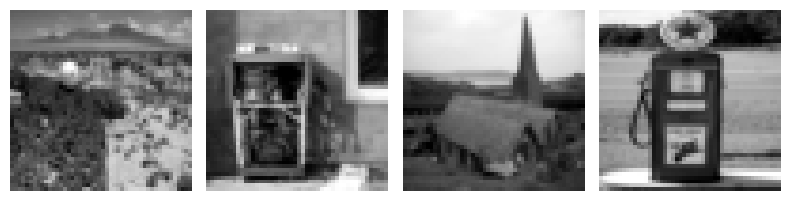

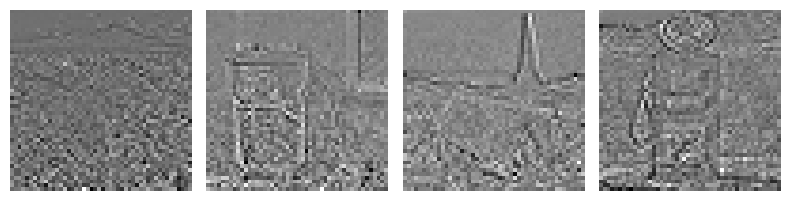

In [8]:
whitened = whiten_images(test_images, algorithm = 'cholesky', stats = whitened_stats, epsilon = 1e-2)

display_images(test_images)
display_whitened_images(whitened)

Additionally, we provide a fourier-based decorrelation based method that is only applicaple to greyscale images.

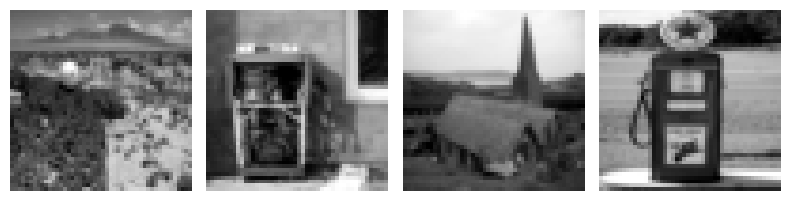

torch.Size([32, 1, 48, 48])


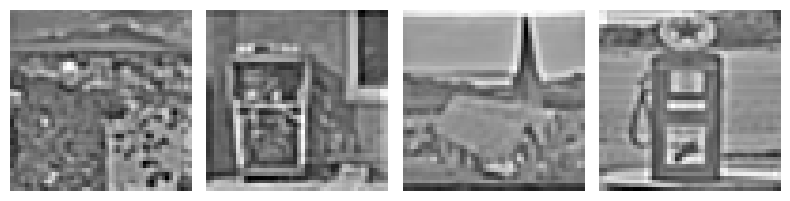

In [9]:
from sparsecoding.transforms import whiten_images

whitened = whiten_images(test_images, algorithm = 'frequency')

display_images(test_images)
print(whitened.shape)
display_whitened_images(whitened)

Since our PCA and ZCA transforms are based on the well known PCA transform, we also have ability to select number the number of principal components (eigenvalues and eigenvectors) that we use in our whitening. We provide the ability to specificy the number of components that explain a certain percentage of variance ($0 \lt \text{n\_components} \lt 1 $), or just a set number of components ($\text{n\_components} \gt 1$). It is important to note that we **do not** reduce the dimensionality of our dataset when selecting less components. Instead we zero out the removed components.

torch.Size([32, 1, 48, 48])


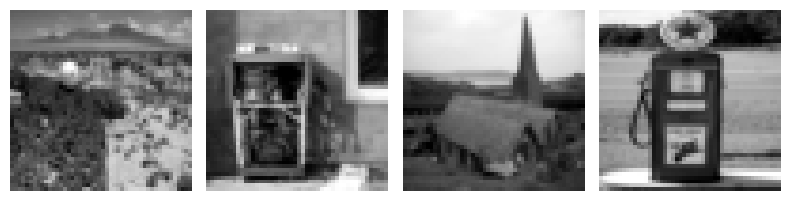

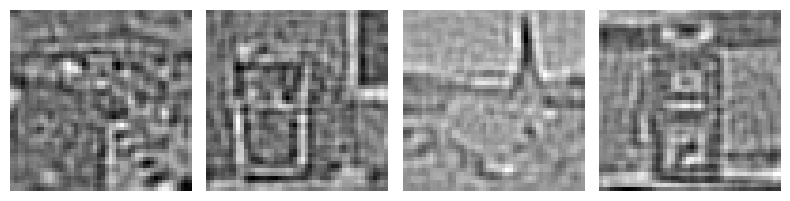

In [ ]:
whitened = whiten_images(test_images,
                         algorithm = 'zca', 
                         stats = whitened_stats, 
                         n_components = 0.975)

print(whitened.shape)
display_images(test_images)
display_whitened_images(whitened)

Finally, let's see how to use this in conjunction with a Pytorch Dataloader. We provide functionality to compose whitening with any series of transforms using `WhiteningTransform()`. It takes in the exact same parameters as `whiten`, so syntactically it's an easy switch. Just plug it with the rest of your transforms and you're ready to go!

For demonstrative purposes, we're going to download a new dataset and show how to use a precomputed stats Dict when transforming your data. It works pretty well considering it was computed on planes and applied to faces, but in general you should compute your whitening statistics on a dataset closer to your target.

Files already downloaded and verified


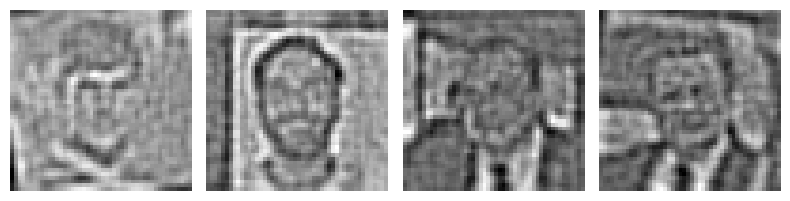

In [ ]:
from sparsecoding.transforms import WhiteningTransform

def load_LFW_dataset_whitened(
    data_dir: str = './img',
    color: bool = False,
    algorithm: str = 'zca',
    stats = None,
    **whitening_kwargs
) -> DataLoader:

    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1) if not color else transforms.Lambda(lambda x: x),
        WhiteningTransform(algorithm=algorithm, stats=stats, **whitening_kwargs)
    ])

    dataset = datasets.LFWPeople(
        root=data_dir,
        download=True,
        transform=transform,
    )

    loader = DataLoader(
        dataset,
        batch_size=42,
        num_workers=2,
    )

    return loader


# Load dataset with ZCA whitening
zca_loader = load_LFW_dataset_whitened(
    algorithm='zca',
    color=False,
    stats = whitened_stats,
    epsilon = 1e-2
)

# How you would do it for frequency based decorrelation
#freq_loader = load_LFW_dataset_whitened(
#    algorithm='frequency',
#    color=False,
#)

images = next(iter(zca_loader))[0]
display_whitened_images(images)



# Misc

- We **do not** stop NaN values by default when whitening data. This can be controlled by epsilon. We do not want to alter results without you controlling it.

- Torch.linalg.eigh can get prohibitive (time and compute) as $D$ increases, we do not recommend using covariance based whitening for images larger than $64$x$64$.

Text(0, 0.5, 'time (s)')

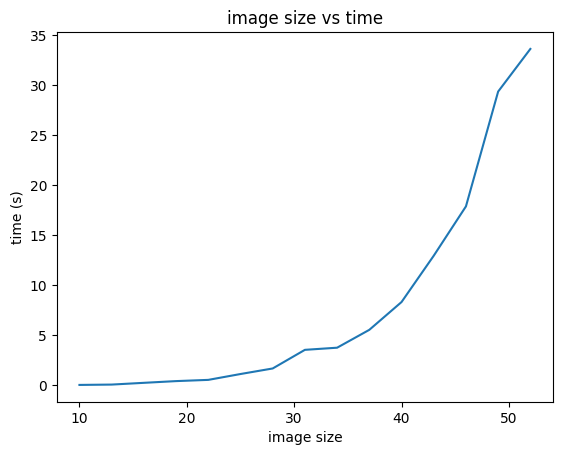

In [ ]:

def time_test(
    D, # sqrt of data dimensionality
):


  X = torch.randn(2000 * D, D* D)
  start_time = time.time()
  stats = compute_whitening_stats(X)
  end_time = time.time()

  return end_time - start_time

times = []
img_size = []
for i in range(10, 54, 3):
  img_size.append(i)
  times.append(time_test(i))

plt.plot(img_size, times)

plt.title('image size vs time')
plt.xlabel('image size')
plt.ylabel('time (s)')